In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, AUC, Accuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from typing import Union

### load images

In [ ]:
datapath = '/content/drive/MyDrive/Images_face_classificator/data/'
train_female = datapath + "Female/"
train_male = datapath + "Male/"
test_male = datapath + "Test_Male/"
test_female = datapath +  "Test_Female/"

In [ ]:
height, width = (225, 225)

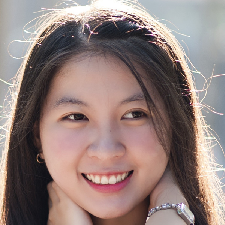

In [ ]:
i = os.listdir(train_female)[300]
load_img(train_female + i, target_size=(height, width), keep_aspect_ratio=True)

In [ ]:
# Load images and resize them
def load_images(path: str, label: int) -> np.ndarray:
  XC = np.array([
      img_to_array(load_img(path + i, target_size=(height, width), keep_aspect_ratio=True)) / 255
      for i in os.listdir(path)
    ])
  yC = np.array([label]*XC.shape[0])
  return (XC, yC)

In [8]:

X_train_female, y_train_female = load_images(path=train_female, label=1)
X_train_male, y_train_male = load_images(path=train_male, label=0)

X_test_female, y_test_female = load_images(path=test_female, label=1)
X_test_male, y_test_male = load_images(path=test_male, label=0)

In [9]:
X_train_ = np.concatenate((X_train_female, X_train_male), axis=0)
y_train_ = np.concatenate((y_train_female, y_train_male), axis=0)
X_test = np.concatenate((X_test_female, X_test_male), axis=0)
y_test = np.concatenate((y_test_female, y_test_male), axis=0)

In [10]:
test_args = np.random.choice(y_train_.shape[0], int(y_train_.shape[0]*0.1), replace=False)
train_args = [i for i in range(y_train_.shape[0]) if i not in test_args]
np.random.shuffle(train_args)

In [11]:
X_train, y_train = X_train_[train_args, :, :, :], y_train_[train_args]
X_eval, y_eval = X_train_[test_args, :, :, :], y_train_[test_args]

### convert to tensor and batch it

In [13]:
def tenconv(data:Union[np.ndarray, list]) -> tf.Tensor:
  """
  Function to convert to tensor. Build ontop of tf.convert_to_tensor
  Args:
    - data: numpy array or list of numpy arrays
  Returns:
    - tensorflow tensor from data
  """
  if isinstance(data, np.ndarray):
    return tf.convert_to_tensor(data, dtype=tf.float32)
  if isinstance(data, list):
    return [tf.convert_to_tensor(i, dtype=tf.float32) for i in data]

In [14]:
X_train, y_train = tenconv([X_train, y_train])
X_test, y_test = tenconv([X_test, y_test])
X_eval, y_eval = tenconv([X_eval, y_eval])

In [ ]:
# tensorize
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))

In [ ]:
# batchsize
batch_size = 12
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=800)
test_dataset = test_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

### Model

In [ ]:
class GenderClassification(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.conv1 = Conv2D(10, (7, 7), activation='relu')
        self.maxpool1 = MaxPool2D((6, 6))
        self.conv2 = Conv2D(20, (7, 7), activation='relu')
        self.maxpool2 = MaxPool2D((6, 6))
        self.conv3 = Conv2D(32, (5, 5), activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):

        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)


In [ ]:
# Instantiate the model
model = GenderClassification()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=["accuracy", AUC()])

In [19]:
model_path = '/content/drive/MyDrive/Images_face_classificator/Models/augmented/'

In [ ]:
def print_eval(path: str) -> None:
  model.load_weights(path)
  test_ = model.evaluate(test_dataset, verbose=0)
  valid_ = model.evaluate(validation_dataset, verbose=0)
  train_ = model.evaluate(train_dataset, verbose=0)
  print(f"Accuracy: train - {train_[1]:.2f}, test - {test_[1]:.2f}, validation - {valid_[1]:.2f}")
  print(f"AUC: train - {train_[2]:.2f}, test - {test_[2]:.2f}, vallidation - {valid_[2]:.2f}")

In [ ]:
model.build((32, 225, 225, 3))

In [ ]:
all_models = os.listdir(model_path)

### Individual compressed metrics


| Model               | Accuracy (Train) | Accuracy (Test) | Accuracy (Validation) | AUC (Train) | AUC (Test) | AUC (Validation) |
|---------------------|------------------|-----------------|-----------------------|-------------|------------|------------------|
| Without Augmentation 1 | 0.64             | 0.50            | 0.64                  | 0.64        | 0.57       | 0.61             |
| Without Augmentation 2 | 0.63             | 0.50            | 0.67                  | 0.72        | 0.77       | 0.75             |
| Without Augmentation 3 | 0.83             | 0.82            | 0.83                  | 0.91        | 0.91       | 0.91             |
| Without Augmentation 4 | 0.78             | 0.75            | 0.77                  | 0.86        | 0.86       | 0.84             |
| Without Augmentation 5 | 0.79             | 0.84            | 0.76                  | 0.91        | 0.91       | 0.93             |
| Without Augmentation 6 | 0.78             | 0.71            | 0.76                  | 0.85        | 0.86       | 0.85             |
| With Augmentation 1   | 0.85             | 0.80            | 0.85                  | 0.92        | 0.90       | 0.92             |
| With Augmentation 2   | 0.89             | 0.81            | 0.89                  | 0.96        | 0.92       | 0.95             |
| With Augmentation 3   | 0.92             | 0.79            | 0.89                  | 0.96        | 0.90       | 0.97             |
| With Augmentation 4   | 0.90             | 0.81            | 0.87                  | 0.96        | 0.91       | 0.95             |
| With Augmentation 5   | 0.90             | 0.86            | 0.93                  | 0.97        | 0.94       | 0.97             |
| With Augmentation 6   | 0.92             | 0.85            | 0.89                  | 0.98        | 0.92       | 0.97             |
| With Augmentation 7   | 0.86             | 0.85            | 0.81                  | 0.94        | 0.92       | 0.91             |


### Metrics

In [ ]:
print_eval(model_path + "simple_82.h5")

Accuracy: train - 0.64, test - 0.50, validation - 0.64
AUC: train - 0.64, test - 0.57, vallidation - 0.61


In [ ]:
print_eval(model_path + "simple_8.h5")

Accuracy: train - 0.63, test - 0.50, validation - 0.67
AUC: train - 0.72, test - 0.77, vallidation - 0.75


In [ ]:
print_eval(model_path + "simple_9.h5")

Accuracy: train - 0.83, test - 0.82, validation - 0.83
AUC: train - 0.91, test - 0.91, vallidation - 0.91


In [ ]:
print_eval(model_path + "simple_AUC.h5")

Accuracy: train - 0.78, test - 0.75, validation - 0.77
AUC: train - 0.86, test - 0.86, vallidation - 0.84


In [ ]:
print_eval(model_path + "simple_AUC_1.h5")

Accuracy: train - 0.79, test - 0.84, validation - 0.76
AUC: train - 0.91, test - 0.91, vallidation - 0.93


In [ ]:
print_eval(model_path + "simple_AUC_3.h5")

Accuracy: train - 0.78, test - 0.71, validation - 0.76
AUC: train - 0.85, test - 0.86, vallidation - 0.85


In [ ]:
print_eval(model_path + "simple_AUC_aug.h5")

Accuracy: train - 0.85, test - 0.80, validation - 0.85
AUC: train - 0.92, test - 0.90, vallidation - 0.92


In [ ]:
print_eval(model_path + "simple_AUC_aug_1.h5")

Accuracy: train - 0.89, test - 0.81, validation - 0.89
AUC: train - 0.96, test - 0.92, vallidation - 0.95


In [ ]:
print_eval(model_path + "simple_AUC_aug_2.h5")

Accuracy: train - 0.92, test - 0.79, validation - 0.89
AUC: train - 0.96, test - 0.90, vallidation - 0.97


In [ ]:
print_eval(model_path + "simple_AUC_aug_3.h5")

Accuracy: train - 0.90, test - 0.81, validation - 0.87
AUC: train - 0.96, test - 0.91, vallidation - 0.95


In [ ]:
print_eval(model_path + "simple_AUC_aug_4.h5")

Accuracy: train - 0.90, test - 0.86, validation - 0.93
AUC: train - 0.97, test - 0.94, vallidation - 0.97


In [ ]:
print_eval(model_path + "simple_AUC_aug_6.h5")

Accuracy: train - 0.92, test - 0.85, validation - 0.89
AUC: train - 0.98, test - 0.92, vallidation - 0.97


In [ ]:
print_eval(model_path + "simple_AUC_aug_7.h5")

Accuracy: train - 0.86, test - 0.85, validation - 0.81
AUC: train - 0.94, test - 0.92, vallidation - 0.91


In [ ]:
model.summary()

Model: "gender_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1480      
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  9820      
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple                  16032     
                                                                 
 flatten (Flatten)           multiple        

### Ensemble of estimations

In [ ]:
all_models = os.listdir(model_path)

In [ ]:
predictions = []
for i in all_models:
  model.load_weights(model_path + i)
  pred = model.predict(test_dataset)
  pred.append(predictions)